# **CAPSTONE PROJECT 3**

#### ***Workflow***

- Data & Domain Understanding
- Data Preperation
    1.  Data Cleaning
    2.  Correlation Check (Feature Selection)
    3.  Preprocessing: Encoding & Scaling
- Create Pipeline
- Model Benchmarking
- Pick 2 best model to **Tune**
- Pick the best model from tuning
- Save the model to **Pickle**
- Create **Interface** for user to do an instant simulation

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import stats, spearmanr

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

## **Data & Domain Understanding**

#### *Columns*

| **Columns** | **Type** | **Description** |
| --- | --- | --- |
| Vehicle Class	 | Object | Type of vehicle insured. | 
| Coverage | Object | Level of insurance coverage the policy offers. | 
| Renew Offer Type	 | Object | Type of renewal offer, may reflect different terms, prices, or benefits designed to retain customers. | 
| EmploymentStatus | Object | Employment status of the policyholder. Might correlate with the policyholder's ability to pay premiums or their risk profile. | 
| Marital Status | Object | Indicates whether the policyholder is "Divorced", "Married", or "Single". | 
| Education | Object | Highest level of education attained by the policyholder. | 
| Number of Policies | Float | The number of policies held by a policyholder with the insurance company. Could indicate customer loyalty or the complexity of the customer's insurance needs.|
| Monthly Premium Auto | Float | Represents the monthly premium amount for the auto insurance policy |
| Total Claim Amount | Float | The total amount claimed by the policyholder. |
| Income | Float | The income of the policyholder. |
| Customer Lifetime Value | Float | Represents the total value a customer is expected to bring to the company over the lifetime of their relationship. Used to identify high-value customers for targeted marketing and personalized services. |

#### *Target Description*

**Customer Lifetime Value** : A metric that represents the total amount of money a customer is expected to spend on our products or services over the entirety of their relationship with our company. CLV is used to:
- Customer segmentation.
- Long-term planning of customer relationships.
- Product/Service development

#### *Problems & Goals*

- **Problems** : Companies often misallocate marketing and retention efforts, spending too much on low-value customers and too little on high-value ones.
- **Goals** : To develop a model that can accurately predict the lifetime value of customers, enabling targeted strategies, and efficiently allocate marketing & retention budgets towards high-value customers.

In [54]:
df = pd.read_csv('data_customer_lifetime_value.csv')
df

,Vehicle Class,Coverage,Renew Offer Type,EmploymentStatus,Marital Status,Education,Number of Policies,Monthly Premium Auto,Total Claim Amount,Income,Customer Lifetime Value
0,Four-Door Car,Extended,Offer1,Retired,Divorced,High School or Below,2.0,90.0,571.479602,11828.0,10083.486880
1,Four-Door Car,Basic,Offer1,Employed,Married,College,6.0,62.0,114.514440,44762.0,4943.386117
2,Two-Door Car,Basic,Offer1,Retired,Married,Master,2.0,62.0,257.248789,21514.0,11981.984810
3,Four-Door Car,Premium,Offer3,Disabled,Married,High School or Below,1.0,116.0,556.800000,17913.0,4550.856045
4,Two-Door Car,Basic,Offer3,Medical Leave,Married,High School or Below,1.0,62.0,355.820799,19030.0,2372.155492
...,...,...,...,...,...,...,...,...,...,...,...
5664,Four-Door Car,Basic,Offer4,Unemployed,Single,High School or Below,1.0,74.0,532.800000,0.0,2442.216651
5665,Four-Door Car,Premium,Offer1,Employed,Divorced,Bachelor,2.0,109.0,523.200000,27778.0,12904.943360
5666,Four-Door Car,Basic,Offer1,Employed,Single,Bachelor,1.0,62.0,44.780402,84658.0,2447.053134
5667,Luxury SUV,Extended,Offer2,Employed,Divorced,Master,7.0,239.0,1294.700423,22705.0,19160.989940


## **Data Preperation**

1. Correlation Check
    - Which feature that has a significant correlation to the target (CLV)?
2. Normality Check
    - Which Scaler to use?
3. Outliers Check
    - Which data should be dropped?

In [57]:
pd.DataFrame({
    'features': df.columns.values,
    'data_type': df.dtypes.values,
    'null_values': df.isna().mean().values * 100,
    'n_unique': df.nunique().values,
    'sample_unique': [df[col].unique() for col in df.columns]
})

,features,data_type,null_values,n_unique,sample_unique
0,Vehicle Class,object,0.0,6,"[Four-Door Car, Two-Door Car, SUV, Sports Car,..."
1,Coverage,object,0.0,3,"[Extended, Basic, Premium]"
2,Renew Offer Type,object,0.0,4,"[Offer1, Offer3, Offer2, Offer4]"
3,EmploymentStatus,object,0.0,5,"[Retired, Employed, Disabled, Medical Leave, U..."
4,Marital Status,object,0.0,3,"[Divorced, Married, Single]"
5,Education,object,0.0,5,"[High School or Below, College, Master, Bachel..."
6,Number of Policies,float64,0.0,9,"[2.0, 6.0, 1.0, 8.0, 5.0, 3.0, 7.0, 4.0, 9.0]"
7,Monthly Premium Auto,float64,0.0,191,"[90.0, 62.0, 116.0, 107.0, 101.0, 66.0, 65.0, ..."
8,Total Claim Amount,float64,0.0,3274,"[571.479602, 114.51444, 257.248789, 556.8, 355..."
9,Income,float64,0.0,3625,"[11828.0, 44762.0, 21514.0, 17913.0, 19030.0, ..."


### **Correlation Check**

#### Numerical

Customer Lifetime Value    1.000000
Monthly Premium Auto       0.402297
Total Claim Amount         0.215354
Income                     0.025698
Number of Policies         0.024721
Name: Customer Lifetime Value, dtype: float64


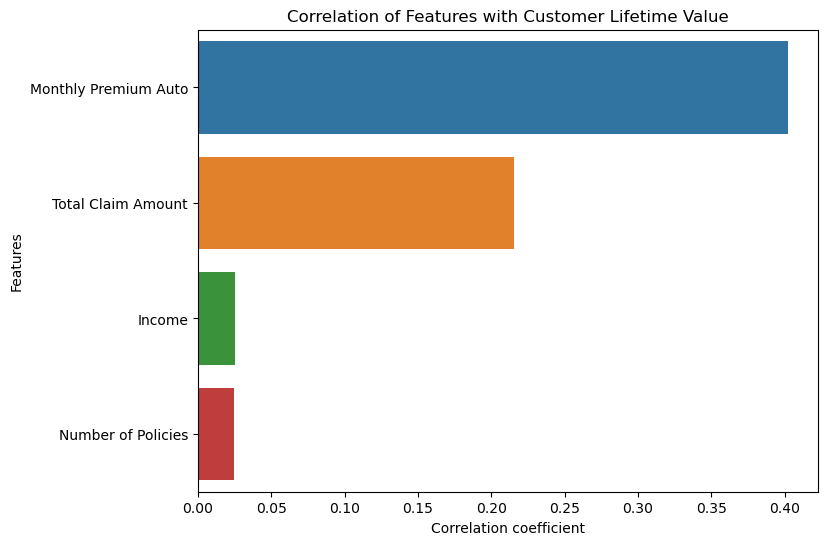

In [58]:
correlation_matrix = df.select_dtypes(include=['float64']).corr()

clv_correlations = correlation_matrix['Customer Lifetime Value'].sort_values(ascending=False)

print(clv_correlations)

clv_correlations = clv_correlations.drop('Customer Lifetime Value')

plt.figure(figsize=(8, 6))
sns.barplot(x=clv_correlations.values, y=clv_correlations.index)
plt.title('Correlation of Features with Customer Lifetime Value')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.show()

In [59]:
float_columns = ['Number of Policies', 'Monthly Premium Auto', 'Total Claim Amount', 'Income']

for col in float_columns:
    corr, p_value = spearmanr(df[col], df['Customer Lifetime Value'])

    if p_value < 0.05:
        print(f"{col} vs CLV:\nCorrelation: {corr:.4f} | P-value: {p_value:.4g} (significant)\n")
    else:
        print(f"{col} vs CLV:\nCorrelation: {corr:.4f} | P-value: {p_value:.4g} (not significant)\n")

Number of Policies vs CLV:
Correlation: 0.4915 | P-value: 0 (significant)

Monthly Premium Auto vs CLV:
Correlation: 0.4596 | P-value: 2.038e-294 (significant)

Total Claim Amount vs CLV:
Correlation: 0.2052 | P-value: 5.959e-55 (significant)

Income vs CLV:
Correlation: 0.0527 | P-value: 7.103e-05 (significant)



#### Categorical

**ANOVA**: Categorical vs Numerical Continous

In [60]:
categorical_columns = ['Vehicle Class', 'Coverage', 'Renew Offer Type', 'EmploymentStatus', 'Marital Status', 'Education']


for col in categorical_columns:
    grouped = df.groupby(col)['Customer Lifetime Value']
    anova_results = stats.f_oneway(*[group for name, group in grouped])
    print(f'{col}: F-statistic={anova_results.statistic:.2f}, p-value={anova_results.pvalue:.4f}')
    
    # Interpretation of the p-value
    if anova_results.pvalue < 0.05:
        print(f"Significant.\n")
    else:
        print(f"Not Significant.\n")


Vehicle Class: F-statistic=171.19, p-value=0.0000
Significant.

Coverage: F-statistic=91.21, p-value=0.0000
Significant.

Renew Offer Type: F-statistic=19.58, p-value=0.0000
Significant.

EmploymentStatus: F-statistic=1.97, p-value=0.0963
Not Significant.

Marital Status: F-statistic=0.80, p-value=0.4511
Not Significant.

Education: F-statistic=3.49, p-value=0.0075
Significant.



### **Normality Check**

To decide which scaler to use

- Monthly Premium Auto

In [107]:
shapiro_test = stats.shapiro(df['Monthly Premium Auto'])
print("Shapiro-Wilk Test:")
print("Statistic:", shapiro_test[0], "p-value:", shapiro_test[1])

# Interpret the p-value
alpha = 0.05
if shapiro_test[1] > alpha:
    print('Distribusi normal(fail to reject H0)')
else:
    print('Tidak berdistribusi normal (reject H0)')

Shapiro-Wilk Test:
Statistic: 0.7871346473693848 p-value: 0.0
Tidak berdistribusi normal (reject H0)


- Total Claim Amount

In [62]:
shapiro_test = stats.shapiro(df['Total Claim Amount'])
print("Shapiro-Wilk Test:")
print("Statistic:", shapiro_test[0], "p-value:", shapiro_test[1])

# Interpret the p-value
alpha = 0.05
if shapiro_test[1] > alpha:
    print('Distribusi normal(fail to reject H0)')
else:
    print('Tidak berdistribusi normal (reject H0)')

Shapiro-Wilk Test:
Statistic: 0.8930978775024414 p-value: 0.0
Tidak berdistribusi normal (reject H0)


- Income

In [63]:
shapiro_test = stats.shapiro(df['Income'])
print("Shapiro-Wilk Test:")
print("Statistic:", shapiro_test[0], "p-value:", shapiro_test[1])

# Interpret the p-value
alpha = 0.05
if shapiro_test[1] > alpha:
    print('Distribusi normal(fail to reject H0)')
else:
    print('Tidak berdistribusi normal (reject H0)')

Shapiro-Wilk Test:
Statistic: 0.9217522740364075 p-value: 0.0
Tidak berdistribusi normal (reject H0)


- Customer Lifetime Value

In [64]:
shapiro_test = stats.shapiro(df['Customer Lifetime Value'])
print("Shapiro-Wilk Test:")
print("Statistic:", shapiro_test[0], "p-value:", shapiro_test[1])

# Interpret the p-value
alpha = 0.05
if shapiro_test[1] > alpha:
    print('Distribusi normal(fail to reject H0)')
else:
    print('Tidak berdistribusi normal (reject H0)')

Shapiro-Wilk Test:
Statistic: 0.7043521404266357 p-value: 0.0
Tidak berdistribusi normal (reject H0)


---
**Normality Check Conclusion**: Robust Scaler is the best scaling method for non-normally distributed

---

### **Outliers Check**

In [65]:
Q1 = df['Customer Lifetime Value'].quantile(0.25)
Q3 = df['Customer Lifetime Value'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


outliers = df[(df['Customer Lifetime Value'] < lower_bound) | (df['Customer Lifetime Value'] > upper_bound)]
print(f"Number of outliers in 'Customer Lifetime Value': {len(outliers)}")


Number of outliers in 'Customer Lifetime Value': 499


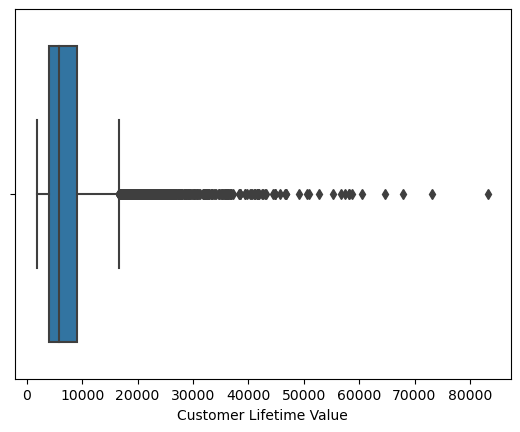

In [66]:
sns.boxplot(x=df['Customer Lifetime Value'])
plt.show()


CLV column Outliers: **8%**

In [67]:
df_no_outliers = df[(df['Customer Lifetime Value'] >= lower_bound) & (df['Customer Lifetime Value'] <= upper_bound)]
df_no_outliers

,Vehicle Class,Coverage,Renew Offer Type,EmploymentStatus,Marital Status,Education,Number of Policies,Monthly Premium Auto,Total Claim Amount,Income,Customer Lifetime Value
0,Four-Door Car,Extended,Offer1,Retired,Divorced,High School or Below,2.0,90.0,571.479602,11828.0,10083.486880
1,Four-Door Car,Basic,Offer1,Employed,Married,College,6.0,62.0,114.514440,44762.0,4943.386117
2,Two-Door Car,Basic,Offer1,Retired,Married,Master,2.0,62.0,257.248789,21514.0,11981.984810
3,Four-Door Car,Premium,Offer3,Disabled,Married,High School or Below,1.0,116.0,556.800000,17913.0,4550.856045
4,Two-Door Car,Basic,Offer3,Medical Leave,Married,High School or Below,1.0,62.0,355.820799,19030.0,2372.155492
...,...,...,...,...,...,...,...,...,...,...,...
5663,Four-Door Car,Basic,Offer1,Employed,Married,High School or Below,2.0,69.0,446.084760,30595.0,8114.409136
5664,Four-Door Car,Basic,Offer4,Unemployed,Single,High School or Below,1.0,74.0,532.800000,0.0,2442.216651
5665,Four-Door Car,Premium,Offer1,Employed,Divorced,Bachelor,2.0,109.0,523.200000,27778.0,12904.943360
5666,Four-Door Car,Basic,Offer1,Employed,Single,Bachelor,1.0,62.0,44.780402,84658.0,2447.053134


In [68]:
df_no_outliers['Customer Lifetime Value'].max()

16589.71237

In [109]:
Q1 = df['Monthly Premium Auto'].quantile(0.25)
Q3 = df['Monthly Premium Auto'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Monthly Premium Auto'] < lower_bound) | (df['Monthly Premium Auto'] > upper_bound)]
print(f"Number of outliers in 'Monthly Premium Auto': {len(outliers)}")

Number of outliers in 'Monthly Premium Auto': 275


In [110]:
Q1 = df['Total Claim Amount'].quantile(0.25)
Q3 = df['Total Claim Amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Total Claim Amount'] < lower_bound) | (df['Total Claim Amount'] > upper_bound)]
print(f"Number of outliers in 'Total Claim Amount': {len(outliers)}")

Number of outliers in 'Total Claim Amount': 265


In [111]:
Q1 = df['Income'].quantile(0.25)
Q3 = df['Income'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Income'] < lower_bound) | (df['Income'] > upper_bound)]
print(f"Number of outliers in 'Income': {len(outliers)}")

Number of outliers in 'Income': 0


In [112]:
Q1 = df['Number of Policies'].quantile(0.25)
Q3 = df['Number of Policies'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Number of Policies'] < lower_bound) | (df['Number of Policies'] > upper_bound)]
print(f"Number of outliers in 'Number of Policies': {len(outliers)}")

Number of outliers in 'Number of Policies': 264


##### With vs Without CLV Outliers Test

Encoding

In [101]:
education_order = [['High School or Below', 'College', 'Bachelor', 'Master', 'Doctor']]

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'), ['Vehicle Class', 'Coverage', 'Renew Offer Type', 'EmploymentStatus', 'Marital Status']),
        ('ord', OrdinalEncoder(categories=education_order), ['Education']),
        ('rob', RobustScaler(), ['Monthly Premium Auto', 'Total Claim Amount', 'Income', 'Number of Policies'])
    ])

In [102]:
X_no_outliers = df_no_outliers.drop('Customer Lifetime Value', axis=1)
y_no_outliers = df_no_outliers['Customer Lifetime Value']

X_with_outliers = df.drop('Customer Lifetime Value', axis=1)
y_with_outliers = df['Customer Lifetime Value']

In [103]:
X_no_outliers_preprocessed = preprocessor.fit_transform(X_no_outliers)
X_with_outliers_preprocessed = preprocessor.transform(X_with_outliers)

Split

In [104]:

X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
    X_no_outliers_preprocessed, 
    y_no_outliers, 
    test_size=0.2, 
    random_state=2024)

X_train_with_outliers, X_test_with_outliers, y_train_with_outliers, y_test_with_outliers = train_test_split(
    X_with_outliers_preprocessed, 
    y_with_outliers, 
    test_size=0.2,
    random_state=2024)

Fit

In [105]:
model_no_outliers = RandomForestRegressor(random_state=2024)
model_no_outliers.fit(X_train_no_outliers, y_train_no_outliers)

model_with_outliers = RandomForestRegressor(random_state=2024)
model_with_outliers.fit(X_train_with_outliers, y_train_with_outliers)

RandomForestRegressor(random_state=2024)

In [106]:
y_pred_no_outliers = model_no_outliers.predict(X_test_no_outliers)
y_pred_with_outliers = model_with_outliers.predict(X_test_with_outliers)

mape_no_outliers = mean_absolute_percentage_error(y_test_no_outliers, y_pred_no_outliers)
mape_with_outliers = mean_absolute_percentage_error(y_test_with_outliers, y_pred_with_outliers)

print(f"MAPE without outliers: {mape_no_outliers}")
print(f"MAPE with outliers: {mape_with_outliers}")

MAPE without outliers: 0.038287113712096935
MAPE with outliers: 0.10401568398110253


---

**Outliers Check Conclusion** : The model performs better without CLV outliers (error delta: 7%)

---

### **Data Preperation Conclusion**

---

**Conclusion**: 
- Correlation test proves that there is not enough significance of correlation between Employment Status and Marital Status to the target (CLV)
- The employment status column is kept and as it should influence the CLV from "Domain Knowledge" perspective 
- The model performs better **without outliers**
- Only drop the target Outliers (8%), since its to much loss of information if all the features that has outliers also be dropped
- Encoders and Scaler: 

| **Columns** | **Type** | **Encoder** | **Scaler** |
| --- | --- | --- | --- |
| Vehicle Class	 | object | OHE | - |
| Coverage | Object |   OHE | - |
| Renew Offer Type	 | object |   OHE | - |
| EmploymentStatus | Object |   OHE | - |
| Marital Status | Object |   OHE | - |
| Education | Object |   Ordinal | - |
| Number of Policies | Float   | - | Robust |
| Monthly Premium Auto | Float   | - | Robust |
| Total Claim Amount | Float   | - | Robust |
| Income | Float |   - | Robust |

---

## **Model Benchmarking** 

In [80]:
x = df_no_outliers.drop(['Customer Lifetime Value', 'Marital Status'], axis=1)
y = df_no_outliers['Customer Lifetime Value']

xtrain, xtest, ytrain, ytest = train_test_split(
    x,
    y, 
    test_size=0.2, 
    random_state=2024)

In [81]:
education_order = [['High School or Below', 'College', 'Bachelor', 'Master', 'Doctor']]

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'), ['Vehicle Class', 'Coverage', 'Renew Offer Type', 'EmploymentStatus']),
        ('ord', OrdinalEncoder(categories=education_order), ['Education']),
        ('rob', RobustScaler(), ['Monthly Premium Auto', 'Total Claim Amount', 'Income', 'Number of Policies'])
    ])

In [82]:
preprocessor_noscaling = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'), ['Vehicle Class', 'Coverage', 'Renew Offer Type', 'EmploymentStatus']),
        ('ord', OrdinalEncoder(categories=education_order), ['Education']),
    ])

Define Models

In [83]:
linreg = LinearRegression()
knn = KNeighborsRegressor()
tree = DecisionTreeRegressor(random_state=2024)
svm = SVR()
forest = RandomForestRegressor(random_state=2024)

vote = VotingRegressor([
    ('mod1', LinearRegression()),
    ('mod2', DecisionTreeRegressor(random_state=2024)),
    ('mod3', KNeighborsRegressor()),
    ('mod4', SVR()),
    ('mod5', RandomForestRegressor(random_state=2024))
])

stack = StackingRegressor(
    estimators=[
        ('mod1', LinearRegression()),
        ('mod2', DecisionTreeRegressor(random_state=2024)),
        ('mod3', KNeighborsRegressor()),
        ('mod4', SVR()),
        ('mod5', RandomForestRegressor(random_state=2024))
    ],
    final_estimator=RandomForestRegressor(random_state=2024)
)


Performance **With Scaling**:

In [84]:
kfold = KFold(n_splits=5, shuffle=True, random_state=2024)

models = [linreg, knn, tree, svm, forest, vote, stack]
model_names = ['Linear Regression', 'KNN', 'Decision Tree', 'SVM', 'Random Forest', 'Ens. Voting', 'Ens. Stacking']
rmse_scores_list = []
stds = []

for model in models:
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', model)])
    
    cv_scores = cross_val_score(model_pipeline, xtrain, ytrain, cv=kfold, scoring='neg_mean_squared_error')
    rmse_scores_list.append(np.sqrt(-cv_scores.mean()))
    stds.append(cv_scores.std())

dfkfold = pd.DataFrame({
    'Model': model_names,
    'AVG RMSE': rmse_scores_list,
    'STD RMSE': stds
})

dfkfold.sort_values('AVG RMSE')


,Model,AVG RMSE,STD RMSE
4,Random Forest,2835.897685,3.812976e+05
6,Ens. Stacking,2855.594586,5.899967e+05
5,Ens. Voting,2858.428009,5.693065e+05
0,Linear Regression,2898.150757,6.316237e+05
1,KNN,3056.181201,3.557355e+05
3,SVM,3378.604674,1.309769e+06
2,Decision Tree,3902.407853,5.292518e+05


In [85]:
kfold = KFold(n_splits=5, shuffle=True, random_state=2024)

models = [linreg, knn, tree, svm, forest, vote, stack]
model_names = ['Linear Regression', 'KNN', 'Decision Tree', 'SVM', 'Random Forest', 'Ens. Voting', 'Ens. Stacking']
mape_scores_list = []
stds = []

for model in models:
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', model)])
    
    
    cv_scores = cross_val_score(model_pipeline, xtrain, ytrain, cv=kfold, scoring='neg_mean_absolute_percentage_error')
   
    mape_scores = -cv_scores
    mape_scores_list.append(mape_scores.mean())
    stds.append(mape_scores.std())

dfkfold = pd.DataFrame({
    'Model': model_names,
    'AVG MAPE': mape_scores_list,
    'STD MAPE': stds
})

dfkfold.sort_values('AVG MAPE')

,Model,AVG MAPE,STD MAPE
4,Random Forest,0.413216,0.012412
6,Ens. Stacking,0.424008,0.013056
5,Ens. Voting,0.425425,0.007534
0,Linear Regression,0.437321,0.005152
1,KNN,0.448804,0.010358
3,SVM,0.462813,0.013663
2,Decision Tree,0.496800,0.024065


Performance **Without Scaling**:

In [86]:
kfold = KFold(n_splits=5, shuffle=True, random_state=2024)

models = [linreg, knn, tree, svm, forest, vote, stack]
model_names = ['Linear Regression', 'KNN', 'Decision Tree', 'SVM', 'Random Forest', 'Ens. Voting', 'Ens. Stacking']
mape_scores_list = []
stds = []

for model in models:
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor_noscaling),
                                     ('regressor', model)])
    
   
    cv_scores = cross_val_score(model_pipeline, xtrain, ytrain, cv=kfold, scoring='neg_mean_absolute_percentage_error')
    
    mape_scores = -cv_scores
    mape_scores_list.append(mape_scores.mean())
    stds.append(mape_scores.std())

dfkfold = pd.DataFrame({
    'Model': model_names,
    'AVG MAPE': mape_scores_list,
    'STD MAPE': stds
})

dfkfold.sort_values('AVG MAPE')


,Model,AVG MAPE,STD MAPE
5,Ens. Voting,0.431579,0.007167
4,Random Forest,0.440607,0.004396
0,Linear Regression,0.441409,0.004915
6,Ens. Stacking,0.442368,0.006706
1,KNN,0.442410,0.006862
2,Decision Tree,0.445566,0.004790
3,SVM,0.463246,0.013708


Benchmarking with **all features** included

In [87]:
x_allfeature = df_no_outliers.drop(['Customer Lifetime Value'], axis=1)
y_allfeature = df_no_outliers['Customer Lifetime Value']

xtrain, xtest, ytrain, ytest = train_test_split(
    x_allfeature,
    y_allfeature, 
    test_size=0.2, 
    random_state=2024)

In [88]:
preprocessor_allfeature = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'), ['Vehicle Class', 'Coverage', 'Renew Offer Type', 'EmploymentStatus', 'Marital Status']),
        ('ord', OrdinalEncoder(categories=education_order), ['Education']),
        ('rob', RobustScaler(), ['Number of Policies', 'Monthly Premium Auto', 'Total Claim Amount', 'Income', 'Number of Policies'])
    ])

In [89]:
kfold = KFold(n_splits=5, shuffle=True, random_state=2024)

models = [linreg, knn, tree, svm, forest, vote, stack]
model_names = ['Linear Regression', 'KNN', 'Decision Tree', 'SVM', 'Random Forest', 'Ens. Voting', 'Ens. Stacking']
mape_scores_list = []
stds = []

for model in models:
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor_allfeature),
                                     ('regressor', model)])
    
    
    cv_scores = cross_val_score(model_pipeline, xtrain, ytrain, cv=kfold, scoring='neg_mean_absolute_percentage_error')
    
    mape_scores = -cv_scores
    mape_scores_list.append(mape_scores.mean())
    stds.append(mape_scores.std())

dfkfold = pd.DataFrame({
    'Model': model_names,
    'AVG MAPE': mape_scores_list,
    'STD MAPE': stds
})

dfkfold.sort_values('AVG MAPE')

,Model,AVG MAPE,STD MAPE
4,Random Forest,0.041596,0.001982
6,Ens. Stacking,0.043820,0.002458
2,Decision Tree,0.049459,0.003864
5,Ens. Voting,0.214196,0.005834
1,KNN,0.310190,0.009508
0,Linear Regression,0.381629,0.003728
3,SVM,0.451371,0.013596


---

Benchmarking Conclusion: **Random Forest** and **Ensemble Stacking** are the two best model.

---

## **Hyperparameter Tuning**

In [113]:
from sklearn.model_selection import RandomizedSearchCV

kfold = KFold(n_splits=5)

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor_allfeature),
                                 ('regressor', forest)])

# Parameter space for Random Forest
param_distributions = {
    'regressor__n_estimators': [100, 200, 300, 400, 500],
    'regressor__max_features': ['auto', 'sqrt'],
    'regressor__max_depth': [10, 20, 30, 40, 50, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__bootstrap': [True, False]
}

random_search = RandomizedSearchCV(model_pipeline, param_distributions=param_distributions, n_iter=500, cv=kfold, scoring='neg_mean_absolute_percentage_error', verbose=2, random_state=2024, n_jobs=-1)

# Fit 
random_search.fit(xtrain, ytrain)

# Best parameters
print("Best param:", random_search.best_params_)

# Best score
best_score = -random_search.best_score_
print("Best (MAPE): {:.2f}%".format(best_score * 100))

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Best param: {'regressor__n_estimators': 500, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 40, 'regressor__bootstrap': False}
Best (MAPE): 4.48%


Ensemble Metalearner tuning

In [114]:
stack_svr = StackingRegressor(
    estimators=[
        ('mod1', LinearRegression()),
        ('mod2', DecisionTreeRegressor(random_state=2024)),
        ('mod3', KNeighborsRegressor()),
        ('mod4', SVR()),
        ('mod5', RandomForestRegressor(random_state=2024))
    ],
    final_estimator=SVR()
)

stack_linreg = StackingRegressor(
    estimators=[
        ('mod1', LinearRegression()),
        ('mod2', DecisionTreeRegressor(random_state=2024)),
        ('mod3', KNeighborsRegressor()),
        ('mod4', SVR()),
        ('mod5', RandomForestRegressor(random_state=2024))
    ],
    final_estimator=LinearRegression()
)

stack_tree = StackingRegressor(
    estimators=[
        ('mod1', LinearRegression()),
        ('mod2', DecisionTreeRegressor(random_state=2024)),
        ('mod3', KNeighborsRegressor()),
        ('mod4', SVR()),
        ('mod5', RandomForestRegressor(random_state=2024))
    ],
    final_estimator=DecisionTreeRegressor(random_state=2024)
)

stack_knn = StackingRegressor(
    estimators=[
        ('mod1', LinearRegression()),
        ('mod2', DecisionTreeRegressor(random_state=2024)),
        ('mod3', KNeighborsRegressor()),
        ('mod4', SVR()),
        ('mod5', RandomForestRegressor(random_state=2024))
    ],
    final_estimator=KNeighborsRegressor()
)

stack_forest = StackingRegressor(
    estimators=[
        ('mod1', LinearRegression()),
        ('mod2', DecisionTreeRegressor(random_state=2024)),
        ('mod3', KNeighborsRegressor()),
        ('mod4', SVR()),
        ('mod5', RandomForestRegressor(random_state=2024))
    ],
    final_estimator=RandomForestRegressor()
)

In [115]:
kfold = KFold(n_splits=5, shuffle=True, random_state=2024)

models = [stack_linreg, stack_knn, stack_tree, stack_svr, stack_forest]
model_names = ['Meta Linear Regression', 'Meta Stack KNN', 'Meta Decision Tree', 'Meta SVM', 'Meta Forest']
mape_scores_list = []
stds = []

for model in models:
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor_allfeature),
                                     ('regressor', model)])
    
    cv_scores = cross_val_score(model_pipeline, xtrain, ytrain, cv=kfold, scoring='neg_mean_absolute_percentage_error')
    
    mape_scores = -cv_scores
    mape_scores_list.append(mape_scores.mean())
    stds.append(mape_scores.std())

dfkfold = pd.DataFrame({
    'Model': model_names,
    'AVG MAPE': mape_scores_list,
    'STD MAPE': stds
})

dfkfold.sort_values('AVG MAPE')

,Model,AVG MAPE,STD MAPE
0,Meta Linear Regression,0.041786,0.001929
4,Meta Forest,0.044207,0.002406
1,Meta Stack KNN,0.047846,0.001456
2,Meta Decision Tree,0.055753,0.004566
3,Meta SVM,0.364977,0.011892


---

**Hyperparameter Tuning Conclusion** : Random forest with default hyperparameter has the lowest MAPE

---

## **Final Model**

- Model: Random Forest (with default parameters)
- Feature Selection : All Feature
- Encoder:
    - OHE = Vehicle Class, Coverage, Renew Offer Type, EmploymentStatus, Marital Status
    - Ordinal = Education
- Scaler: Robust (for Non-gaussian distribution)

In [93]:
forest = RandomForestRegressor(random_state=2024)

final_pipeline = Pipeline(steps=[('preprocessor', preprocessor_allfeature),
                                 ('regressor', forest)])

final_pipeline.fit(xtrain, ytrain)

predictions = final_pipeline.predict(xtest)

In [94]:
mape = np.mean(np.abs((ytest - predictions) / ytest)) * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 3.81%


MAPE final model on test data: **3.84%**

In [95]:
prediction_all = final_pipeline.predict(df_no_outliers)

In [96]:
df_no_outliers['Predictions'] = prediction_all

In [97]:
df_no_outliers

,Vehicle Class,Coverage,Renew Offer Type,EmploymentStatus,Marital Status,Education,Number of Policies,Monthly Premium Auto,Total Claim Amount,Income,Customer Lifetime Value,Predictions
0,Four-Door Car,Extended,Offer1,Retired,Divorced,High School or Below,2.0,90.0,571.479602,11828.0,10083.486880,10120.243481
1,Four-Door Car,Basic,Offer1,Employed,Married,College,6.0,62.0,114.514440,44762.0,4943.386117,4959.728606
2,Two-Door Car,Basic,Offer1,Retired,Married,Master,2.0,62.0,257.248789,21514.0,11981.984810,11675.913508
3,Four-Door Car,Premium,Offer3,Disabled,Married,High School or Below,1.0,116.0,556.800000,17913.0,4550.856045,4519.310819
4,Two-Door Car,Basic,Offer3,Medical Leave,Married,High School or Below,1.0,62.0,355.820799,19030.0,2372.155492,2374.149754
...,...,...,...,...,...,...,...,...,...,...,...,...
5663,Four-Door Car,Basic,Offer1,Employed,Married,High School or Below,2.0,69.0,446.084760,30595.0,8114.409136,8397.826728
5664,Four-Door Car,Basic,Offer4,Unemployed,Single,High School or Below,1.0,74.0,532.800000,0.0,2442.216651,2690.480512
5665,Four-Door Car,Premium,Offer1,Employed,Divorced,Bachelor,2.0,109.0,523.200000,27778.0,12904.943360,12909.692165
5666,Four-Door Car,Basic,Offer1,Employed,Single,Bachelor,1.0,62.0,44.780402,84658.0,2447.053134,2447.929642


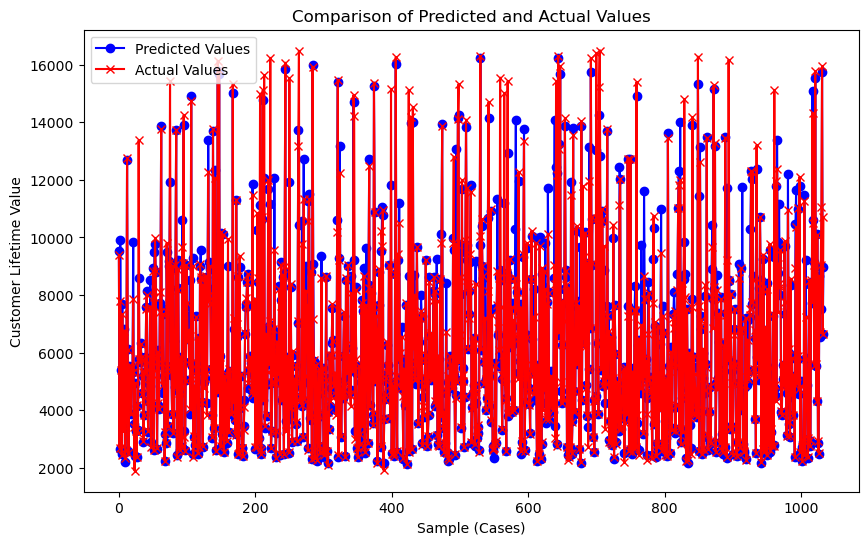

In [98]:
actual = np.array(ytest)

plt.figure(figsize=(10, 6))  
plt.plot(predictions, label='Predicted Values', color='blue', marker='o')  
plt.plot(actual, label='Actual Values', color='red', marker='x') 

plt.title('Comparison of Predicted and Actual Values')  
plt.xlabel('Sample (Cases)')  
plt.ylabel('Customer Lifetime Value')  
plt.legend()  

plt.show()  

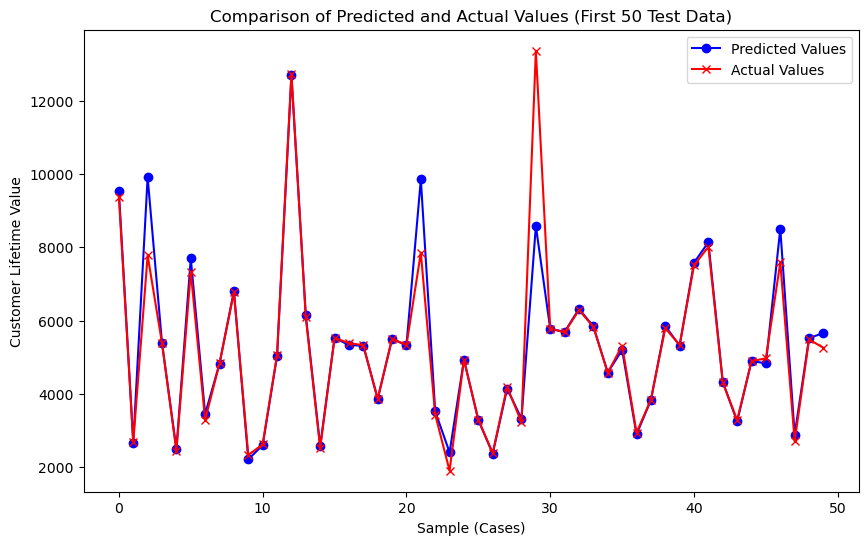

In [99]:
predictions_100 = predictions[:50]
actual_100 = actual[:50]

# Plotting
plt.figure(figsize=(10, 6))  
plt.plot(predictions_100, label='Predicted Values', color='blue', marker='o') 
plt.plot(actual_100, label='Actual Values', color='red', marker='x') 

plt.title('Comparison of Predicted and Actual Values (First 50 Test Data)') 
plt.xlabel('Sample (Cases)')  
plt.ylabel('Customer Lifetime Value')  
plt.legend()  

plt.show()

---

In [100]:
import pickle

pickle.dump(final_pipeline, open('finalmodel_irvan.sav', 'wb'))

## **CONCLUSION**

1. The most suitable model in this scenario is RandomForest with default parameters, achieving a MAPE of 4.15% on cross-validation benchmarking.
2. The model is trained on a dataset that excludes CLV (Customer Lifetime Value) outliers, as this significantly improves performance. Consequently, the model's predictions are most reliable for customer CLV values ranging from 0 to 16,500.
3. It is advisable to develop another model using training data that includes the CLV outliers. This approach offers users options:
    - The model trained without CLV outliers demonstrates a lower MAPE (Mean Absolute Percentage Error), indicating higher accuracy but within a limited CLV range.
    - The model trained with CLV outliers might offer lower overall accuracy but is hypothesized to produce better predictions for higher CLV ranges.
4. A user interface has been developed based on this model, allowing users to make quick predictions by manually inputting the features.

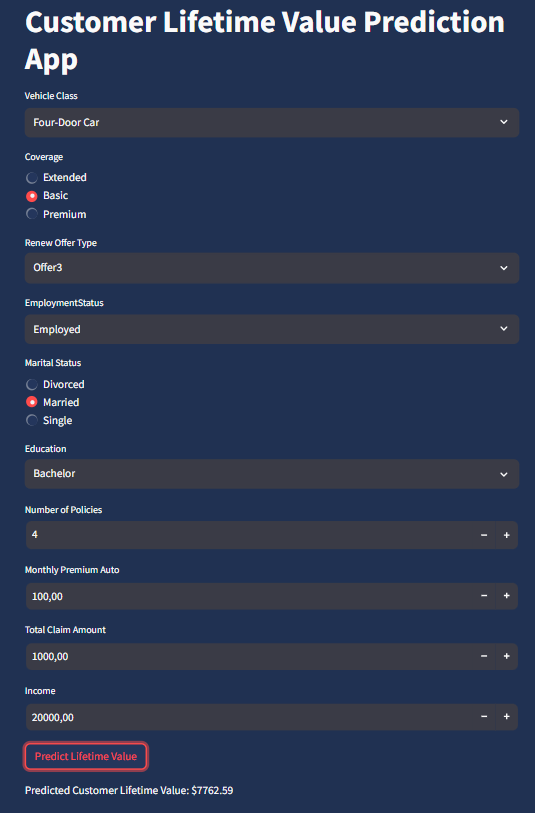
